# Bootstrapping NoteBook: LIBOR,OIS,CSA and SOFR(ESTR) curves construction
--- Jul-19-2020, Alan, Shaolun.du@gmail.com

This is a note book for bootstrapping method on LIBOR, OIS, CSA and SOFR(ESTR) curves. I will bootsrapped them one by one with market quotes from Bloomberg. And details about implementation will be listed in this notebook.

## Section One: LIBOR curve.
The LIBOR forward curve is the market’s projection of LIBOR based on deposit rates, Eurodollar futures and swap data. The forward curve is derived from this information in a process called “bootstrapping”, and is used to price interest rate options like caps and floors, as well as interest rate swaps. The bootstrapping method for LIBOR curve always depends on the most liquidity tradable market contracts which are: 0-3M cash deposits rates, 3M-12M futures rates, 2Y-30Y swaps rates.

A standard market panel information looks like below:

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
market ={'sdate': datetime.date(2020, 7, 16),
         # Cash deposit rates
         'cash': [
                    [datetime.date(2020, 10, 16), 0.27288]
                ], 
         # Deposit day count
         'cash_dc': "ACT/360",
         # Euro dollar futures rates
         'future': [
                     [datetime.date(2020, 9, 16), 0.259713], 
                     [datetime.date(2020, 12, 16), 0.303983], 
                     [datetime.date(2021, 3, 17), 0.207928], 
                     [datetime.date(2021, 6, 16), 0.18155], 
                     [datetime.date(2021, 9, 15), 0.179861], 
                     [datetime.date(2021, 12, 15), 0.197869], 
                     [datetime.date(2022, 3, 16), 0.17557], 
                     [datetime.date(2022, 6, 15), 0.182798]
                 ], 
         # Futures day count
         'future_dc': "ACT/360",
         # US market swap rates
         'swap': [
                     [datetime.date(2022, 7, 16), 0.2212], 
                     [datetime.date(2023, 7, 16), 0.2276], 
                     [datetime.date(2025, 7, 16), 0.3149], 
                     [datetime.date(2027, 7, 16), 0.4402], 
                     [datetime.date(2030, 7, 16), 0.5944], 
                     [datetime.date(2032, 7, 16), 0.6685], 
                     [datetime.date(2035, 7, 16), 0.7415], 
                     [datetime.date(2040, 7, 16), 0.8135], 
                     [datetime.date(2045, 7, 16), 0.8346], 
                     [datetime.date(2050, 7, 16), 0.8413], 
                 ],
         # Swap day count on fixed leg
         'swap_dc': "30/360",
         # Swap fixed leg pay frequency
         'swap_pay_freq':6,
        }

In [3]:
class Day_Counter():
    _dc_norm = dict( {
                '30/360': '30/360',
                '30/360 US': '30/360 US',
                '30U/360': '30/360 US',
                '360/360': '30/360 US',
                '30E/360': '30E/360',
                '30E/360 ISDA': '30E/360 ISDA',
                '30E+/360': '30E+/360',
                'ACTUAL/365': 'ACTUAL/ACTUAL ISDA',
                'ACT/365': 'ACTUAL/ACTUAL ISDA',
                'ACT/ACT': 'ACTUAL/ACTUAL ISDA',
                'ACTUAL/ACTUAL': 'ACTUAL/ACTUAL ISDA',
                'ACTUAL/365 FIXED': 'ACTUAL/365 FIXED',
                'ACT/365 FIXED': 'ACTUAL/365 FIXED',
                'ACTUAL/360': 'ACTUAL/360',
                'ACT/360': 'ACTUAL/360',
                } )
    def __init__( self ):
        self.convention = ""
    def _set_convention(self, convention):
        self.convention = convention
    def _yearfrac( self, 
                   dt1, dt2, 
                   convention="", 
                   **kwargs):
        """ Fractional number of years between two dates 
            according to a given daycount convention
            It can take inputs convention 
            Otherwise use default convention
        """
        if convention == "":
            frac = self._daycount_parameters( dt1, 
                                              dt2, 
                                              self.convention, 
                                              **kwargs)[2]
        else:
            frac = self._daycount_parameters( dt1, 
                                              dt2, 
                                              convention, 
                                              **kwargs)[2]
        return frac
    def _daycount_parameters( self, 
                              dt1, 
                              dt2, 
                              convention,
                              **kwargs):
        """ Return number of days and total 
            number of days and year 
            fraction between dates
        """
        convention = self._dc_norm[convention.upper()]
        y1, m1, d1 = dt1.year, dt1.month, dt1.day
        y2, m2, d2 = dt2.year, dt2.month, dt2.day
        factor = None
        if convention in {'30/360','30/360 US', '30E/360', '30E/360 ISDA', '30E+/360'}:
            if convention == '30/360':
                d1 = min (d1,30)
                if d1 == 30:
                    d2 = min(d2,30)
            elif convention == '30/360 US':
                # US adjustments
                if m1 == 2 and d1 >= 28:
                    d1 = 30
                if m2 == 2 and d2 >= 28:
                    d2 = 30
                if d2 == 31 and d1 >= 30:
                    d2 = 30
                if d1 == 31:
                    d1 = 30
            elif convention == '30E+/360':
                if d1 == 31:
                    d1 = 30
                if d2 == 31:
                    m2 += 1
                    if m2 == 13:
                        m2 = 1
                        y2 += 1
                    d2 = 1
            num_days  = (360*(y2-y1)+30*(m2-m1)+(d2-d1))
            year_days = 360
        elif convention in {'ACTUAL/365 FIXED', 'ACTUAL/365'}:
            num_days  = (dt2-dt1).days
            year_days = 365
        elif convention == 'ACTUAL/360':
            num_days  = (dt2-dt1).days
            year_days = 360
        elif convention == 'ACTUAL/365L':
            yearly_frequency = 'frequency' in kwargs and kwargs['frequency'] =='yearly'
            if yearly_frequency:
                year_days = 366 if self._period_has_29feb(dt1, dt2) else 365
            else:
                year_days = 366 if calendar.isleap(dt2) else 365
            num_days = (dt2-dt1).days
            
        elif convention == 'ACTUAL/ACTUAL ISDA':
            num_days  = 0
            year_days = 0
            if y2 == y1:
                num_days  = (dt2 - dt1).days
                year_days = 365.25
            else:
                """ we need to calculate factor properly
                """
                factor = 0.0
                """ full years between y1 and y2 exclusive
                """
                for y in range(y1+1, y2):
                    yd = 365.25
                    num_days  += yd
                    year_days += yd
                    factor += float(num_days)/year_days
                """ Days in the remaining part of the first year
                """
                num = (datetime.datetime(y1+1, 1, 1).date() - dt1).days
                den = 365.25
                num_days  += num
                year_days += den
                factor += float(num)/den
                """ Days in the beginning of the last year
                """
                num = (dt2 - datetime.datetime(y2, 1, 1).date()).days
                den = 365.25
                num_days += num
                year_days += den
                factor += float(num)/den
        else:
            raise ValueError('Unknown daycount convention \'%s\'' % convention)
    
        if factor is None:
            factor = float(num_days)/year_days
        return num_days, year_days, factor
    
    def _period_has_29feb( self, 
                           dt1, 
                           dt2 ):
        have_29_feb = False
        y1 = dt1.year
        y2 = dt2.year
        for y in range(y1, y2+1):
            if calendar.isleap(y) and (
                (y!=y1 and y!=y2)
                or (y == y1 and dt1<datetime.datetime(y1, 2, 29))
                or (y == y2 and datetime.datetime(y2, 2, 29) <= dt2)):
                have_29_feb = True
        return have_29_feb    
    def _daydiff( self, 
                 dt1, 
                 dt2, 
                 convention, 
                 **kwargs ):
        """ Calculate difference in days between tow days according to a given
            daycount convention
        """
        return self._daycount_parameters( dt1, 
                                          dt2, 
                                          convention, 
                                          **kwargs )[0]

In [4]:
class LIBOR_BtS():
    def __init__(self, market, day_count):
        self.sdate = market['sdate']
        self.cash_rate = market['cash']
        self.cash_dc = market['cash_dc']
        self.future_rate = market['future']
        self.future_dc = market['future_dc']
        self.swap_rate = market['swap']
        self.swap_dc = market['swap_dc']
        self.swap_pay_freq = market['swap_pay_freq']
        # Directly check and fix curve linkage issue after init
        self._check_if_gap()
        self.swap_rate = self._augument_swap_market_linear()
        self.day_count = day_count
        # Return discount factor curve
        self.df_cv = [[self.sdate,1]]
    
    def _start_bootstrap(self):
        # Start bootstrapping
        self._bt_cash_section()
        self._bt_future_section()
        self._bt_swap_section()
    
    def _get_dfs(self):
        # return discounting factors
        return self.df_cv
    
    def _check_if_gap(self):
        # Function to check if there is a gap between different
        # market sections
        self.first_IMM = max(self.sdate, self._get_IMMDate(self.future_rate[0][0]-relativedelta(months = 3)))
        if self.cash_rate[-1][0] < self.first_IMM:
            diff_month = max(1,int((self.future_rate[0][0]-self.first_IMM).days/30))
            print("Date gap between cash rate and future rate...")
            print("Will extend cash rate flat by {} months.".format(diff_month))
            self.cash_rate.append([self.cash_rate[-1][0]+relativedelta(months = diff_month),self.cash_rate[-1][1]])
        last_swap_stub = self.swap_rate[0][0]-relativedelta(months = self.swap_pay_freq)
        if last_swap_stub > self.future_rate[-1][0]:
            # last swap stub has no data to link to future rate
            diff_month = max(1,int((last_swap_stub-self.future_rate[-1][0]).days/30))
            print("Date gap between future rate and swap rate...")
            print("Will extend future rate flat by {} months.".format(diff_month))
            self.future_rate.append([self.future_rate[-1][0]+relativedelta(months = diff_month),self.future_rate[-1][1]])
            
    def _augument_swap_market_linear(self):
        # expend and augument swap market rates using linear interpolation
        diff_month = self.swap_pay_freq
        start_dt = self.swap_rate[0][0]
        end_dt = self.swap_rate[-1][0]
        target_dts = [start_dt+relativedelta(months = diff_month*i) for i in range(int(((end_dt.year - start_dt.year) * 12 + end_dt.month - start_dt.month)/diff_month)+1)]
        swap_inpter_list = []
        for ele in target_dts:
            swap_inpter_list.append([ele,self._get_interp_value(self.swap_rate,ele)])
        return swap_inpter_list
    
    def _bt_cash_section(self):
        # build cash curve section
        self.day_count._set_convention(self.cash_dc) # set day count convention for cash rate
        for ele in self.cash_rate:
            self.df_cv.append([ele[0],1/(1+ele[1]/100*self.day_count._yearfrac(self.sdate,ele[0]))])
            
    def _bt_future_section(self):
        # build futures curve section
        self.day_count._set_convention(self.future_dc) # set day count convention for futures rate
        cur_df = self._get_interp_value(self.df_cv,self.first_IMM)
        cur_date = self.first_IMM
        for ele in self.future_rate:
            nxt_df = cur_df*1/(1+ele[1]/100*self.day_count._yearfrac(cur_date,ele[0]))
            self.df_cv.append([ele[0],nxt_df])
            cur_date = ele[0]
            cur_df = nxt_df
            
    def _bt_swap_section(self):
        self.df_cv = sorted(self.df_cv,key=lambda x:x[0])
        # build swaps curve section
        self.day_count._set_convention(self.cash_dc) # set day count convention for swap rate
        sum_dfs = self._get_sum_dfs(self.swap_rate[0][0]-relativedelta(months = self.swap_pay_freq),self.swap_pay_freq) # return sum of dfs before start
        swap_frequency = relativedelta(months = self.swap_pay_freq)
        cur_date = self.swap_rate[0][0]
        for i in range( 0, len(self.swap_rate)-1 ):
            nxt_date = cur_date+swap_frequency
            yearfrac = self.day_count._yearfrac( cur_date, nxt_date )
            rates    = self.swap_rate[i][1]
            cur_DF   = (100-sum_dfs*rates)/(100+rates*yearfrac)
            self.df_cv.append([cur_date,cur_DF])
            sum_dfs += cur_DF*yearfrac
            cur_date = self.swap_rate[i+1][0]
            
    def _get_sum_dfs(self, start_date, pay_freq):
        # get cumulative dfs before first swap starting date
        sum_dfs = 0
        cur_date = self.sdate
        nxt_date = self.sdate + relativedelta(months = pay_freq)
        start_date = self.swap_rate[0][0]
        while nxt_date < start_date:
            dfs = self._get_interp_value(self.df_cv,nxt_date)
            sum_dfs += dfs*self.day_count._yearfrac(cur_date,nxt_date)
            cur_date = nxt_date
            nxt_date += relativedelta(months = pay_freq)
        return sum_dfs
    
    def _get_interp_value(self, cv, target):
        for iloc in range(1,len(cv)):
            cur_n = cv[iloc-1]
            nxt_n = cv[iloc]
            if cur_n[0]<=target and target<=nxt_n[0]:
                return  (target-cur_n[0])/(nxt_n[0]-cur_n[0])*(nxt_n[1]-cur_n[1])+cur_n[1]
        print(cv,target)
        raise("Cannot find interpolation value...")
        return 0
    
    def _get_IMMDate(self, idate):
        """ Takes 2 digit IMM code and returns effective date 
            as datetime object
        """
        Y,M = idate.year, idate.month
        temp = datetime.date(Y,M,1)
        week_day = temp.weekday()
        if week_day == 2:
            ans_date = temp + datetime.timedelta(days = 14)
        elif week_day < 2:
            ans_date = temp + datetime.timedelta(days = 2-week_day+14)
        elif week_day > 2:
            ans_date = temp + datetime.timedelta(days = 6-week_day+3+14)
        return ans_date
    
    def _plot_market_rate(self):
        # plot market rate curve
        plot_list_x = [ele[0] for ele in self.cash_rate]
        plot_list_y = [ele[1] for ele in self.cash_rate]
        plot_list_x +=  [ele[0] for ele in self.future_rate]
        plot_list_y += [ele[1] for ele in self.future_rate]
        plot_list_x +=  [ele[0] for ele in self.swap_rate]
        plot_list_y += [ele[1] for ele in self.swap_rate]
        fig = plt.plot(plot_list_x,plot_list_y)
        return fig
    
    def _plot_cv_result(self):
        #PLot summary of curves
        dfs = self._get_dfs()
        zeros = [[ele[0],-math.log(ele[1])/self.day_count._yearfrac(self.sdate,ele[0])] for ele in dfs if ele[0]>self.sdate]
        fig,axes = plt.subplots(1,2,figsize=(10,6))
        axes[0].plot([ele[0] for ele in dfs],[ele[1] for ele in dfs])
        axes[0].set_title('Discount factors curve plot')
        axes[1].plot([ele[0] for ele in zeros],[ele[1] for ele in zeros])
        axes[1].set_title('Zero rates curve plot')

In [5]:
Day_Count = Day_Counter()
L_BtS = LIBOR_BtS(market,Day_Count)
L_BtS._start_bootstrap()
dfs = L_BtS._get_dfs()
L_BtS._plot_cv_result()

## Section Two: OIS curve
OIS stands for overnight index swap. An index swap refers to a hedging contract in which a party exchanges a predetermined cash flow with a counter-party on a specified date. A debt, equity or other price index is used as the agreed exchange for one side of this swap. An overnight index swap applies an overnight rate index such as the federal funds. Index swaps are specialized groups of conventional fixed rate swaps, with terms that can be set from three months to more than a year.

The Credit Crises led to profound changes in OTC derivatives market practice, as it is now common that transactions are collateralized in order to mitigate counterparty credit risk. These changes together with issues related to LIBOR quality/credibility, led to market adoption of the overnight index swap (OIS) as the "new risk-free swap curve".

A standard market panel information looks like below:


In [6]:
market ={'sdate': datetime.date(2020, 7, 16),
         # US market OIS swap rates
         'swap': [  [datetime.date(2020, 7, 17), 0.1], 
                    [datetime.date(2020, 7, 23), 0.09], 
                    [datetime.date(2020, 8, 16), 0.0805], 
                    [datetime.date(2020, 10, 16), 0.07], 
                    [datetime.date(2021, 7, 16), 0.0294], 
                    [datetime.date(2022, 7, 16), 0.001], 
                    [datetime.date(2023, 7, 16), 0.004], 
                    [datetime.date(2025, 7, 16), 0.091], 
                    [datetime.date(2030, 7, 16), 0.374],
                    [datetime.date(2035, 7, 16), 0.529],
                    [datetime.date(2040, 7, 16), 0.605],
                    [datetime.date(2050, 7, 16), 0.64],
                 ],
         # Swap day count on fixed leg
         'swap_dc': "ACT/360",
         # Swap fixed leg pay frequency
         # OIS swap always pays annualy and the floating
         # payment cannot be decided before reset date
         'swap_pay_freq':12,
        }

In [7]:
class OIS_BtS():
    def __init__(self, market, day_count):
        self.sdate = market['sdate']
        self.cash_rate,self.swap_rate = self._regroup_market(market['swap'])
        self.swap_dc = market['swap_dc']
        self.swap_pay_freq = market['swap_pay_freq']
        self.swap_rate = self._augument_swap_market_linear()
        self.day_count = day_count
        # Return discount factor curve
        self.df_cv = [[self.sdate,1]]
        
    def _start_bootstrap(self):
        # Start bootstrapping
        self._bt_swap_section()
    
    def _get_dfs(self):
        # return discounting factors
        return self.df_cv 
    
    def _regroup_market(self, market):
        # seperate cash and swap rates
        cash = [ ele for ele in market if ele[0]<=self.sdate+relativedelta(months = 12)]
        swap = [ ele for ele in market if ele[0]>self.sdate+relativedelta(months = 12)]
        return cash,swap
    def _augument_swap_market_linear(self):
        # expend and augument swap market rates using linear interpolation
        diff_month = self.swap_pay_freq
        start_dt = self.swap_rate[0][0]
        end_dt = self.swap_rate[-1][0]
        target_dts = [start_dt+relativedelta(months = diff_month*i) for i in range(int(((end_dt.year - start_dt.year) * 12 + end_dt.month - start_dt.month)/diff_month)+1)]
        swap_inpter_list = []
        for ele in target_dts:
            swap_inpter_list.append([ele,self._get_interp_value(self.swap_rate,ele)])
        return swap_inpter_list
    
    def _bt_swap_section(self):
        # build swaps curve section
        self.day_count._set_convention(self.swap_dc) # set day count convention for swap rate
        for ele in self.cash_rate:
            self.df_cv.append([ele[0],1/(1+ele[1]/100*self.day_count._yearfrac( self.sdate, ele[0] ))])
        self.df_cv = sorted(self.df_cv,key=lambda x:x[0])
        sum_dfs = self._get_sum_dfs(self.swap_rate[0][0]-relativedelta(months = self.swap_pay_freq),self.swap_pay_freq) # return sum of dfs before start
        swap_frequency = relativedelta(months = self.swap_pay_freq)
        cur_date = self.swap_rate[0][0]
        for i in range( 0, len(self.swap_rate)-1 ):
            nxt_date = cur_date+swap_frequency
            yearfrac = self.day_count._yearfrac( cur_date, nxt_date )
            rates    = self.swap_rate[i][1]
            cur_DF   = (100-sum_dfs*rates)/(100+rates*yearfrac)
            self.df_cv.append([cur_date,cur_DF])
            sum_dfs += cur_DF*yearfrac
            cur_date = self.swap_rate[i+1][0]
    
    def _get_sum_dfs(self, start_date, pay_freq):
        # get cumulative dfs before first swap starting date
        sum_dfs = 0
        cur_date = self.sdate
        nxt_date = self.sdate + relativedelta(months = pay_freq)
        start_date = self.swap_rate[0][0]
        while nxt_date < start_date:
            dfs = self._get_interp_value(self.df_cv,nxt_date)
            sum_dfs += dfs*self.day_count._yearfrac(cur_date,nxt_date)
            cur_date = nxt_date
            nxt_date += relativedelta(months = pay_freq)
        return sum_dfs
    
    def _get_interp_value(self, cv, target):
        for iloc in range(1,len(cv)):
            cur_n = cv[iloc-1]
            nxt_n = cv[iloc]
            if cur_n[0]<=target and target<=nxt_n[0]:
                return  (target-cur_n[0])/(nxt_n[0]-cur_n[0])*(nxt_n[1]-cur_n[1])+cur_n[1]
        print(cv,target)
        raise("Cannot find interpolation value...")
        return 0
    
    def _plot_market_rate(self):
        # plot market rate curve
        plot_list_x = [ele[0] for ele in self.cash_rate]
        plot_list_y = [ele[1] for ele in self.cash_rate]
        plot_list_x +=  [ele[0] for ele in self.future_rate]
        plot_list_y += [ele[1] for ele in self.future_rate]
        plot_list_x +=  [ele[0] for ele in self.swap_rate]
        plot_list_y += [ele[1] for ele in self.swap_rate]
        fig = plt.plot(plot_list_x,plot_list_y)
        return fig
    
    def _plot_cv_result(self):
        #PLot summary of curves
        dfs = self._get_dfs()
        zeros = [[ele[0],-math.log(ele[1])/self.day_count._yearfrac(self.sdate,ele[0])] for ele in dfs if ele[0]>self.sdate]
        fig,axes = plt.subplots(1,2,figsize=(10,6))
        axes[0].plot([ele[0] for ele in dfs],[ele[1] for ele in dfs])
        axes[0].set_title('Discount factors curve plot')
        axes[1].plot([ele[0] for ele in zeros],[ele[1] for ele in zeros])
        axes[1].set_title('Zero rates curve plot')

In [8]:
Day_Count = Day_Counter()
O_BtS = OIS_BtS(market,Day_Count)
O_BtS._start_bootstrap()
dfs = O_BtS._get_dfs()
O_BtS._plot_cv_result()

## Section Three: CSA curve
Many OTC derivative transactions are traded under Credit Support Annexes(CSAs) which explicity stipulate terms for collateral posting. This notebook decribes how CSA curves are used to price collateralized interests rate swaps. These CSA curves are calibrated to cross-currency basis swap quotes via standard bootstrapping under the assumption that the implied FX forwards should be invariant to the currency in which the collateral is posted.

A CSA stipulates the currency in which the collateral of OTC derivative transactions can be posted. For example, if we have USDJPY swap and CSA indicates USD as the collateral posted, hence its cashflows are discounted using the USD OIS curve. But the JPY cashflows have to be discounted using the JPY vs. USD basis curve which is often quoted as "CSA-implied OIS" curve because it is equivalent to the IS curve in the collateral currency with appropriate FX forward adjustments.

Please see the below graph to explain how the forward non-arbitrage condition hold under implied rates:
> JPY--(spot FX)--> USD--(OIS rate)-->FV(USD) 

> JPY--(implied deposit)-->JPY<--(forward FX)--USD

Both side should hold equal to each other which means 

$ \frac{FX_{T}^{fwd}}{FX_{0}^{fwd}} = \frac{Dis^{OIS}_{T}}{Dis^{CSA}_{T}}$

So from above we know, the implied CSA curve is the curve that holds forward market invariant. We want to solve for implied deposit rate for CSA curve, all we have to do is to build the forward market curve and OIS curve at collaterlized currency.

A standard market panel information looks like below:

In [9]:
market ={'sdate': datetime.date(2020, 7, 16),
         # US market OIS swap rates
         'swap': [  [datetime.date(2020, 7, 17), 0.1], 
                    [datetime.date(2020, 7, 23), 0.09], 
                    [datetime.date(2020, 8, 16), 0.0805], 
                    [datetime.date(2020, 10, 16), 0.07], 
                    [datetime.date(2021, 7, 16), 0.0294], 
                    [datetime.date(2022, 7, 16), 0.001], 
                    [datetime.date(2023, 7, 16), 0.004], 
                    [datetime.date(2025, 7, 16), 0.091], 
                    [datetime.date(2030, 7, 16), 0.374]
                 ],
         # Swap day count on fixed leg
         'swap_dc': "ACT/360",
         # Swap fixed leg pay frequency
         # OIS swap always pays annualy and the floating
         # payment cannot be decided before reset date
         'swap_pay_freq':12,
         # Spot FX
         'spot_ccy':1.1412,
         'fwd_points': [
                        [datetime.date(2020, 7, 16)+relativedelta(months=1),0.00077],
                        [datetime.date(2020, 7, 16)+relativedelta(months=3),0.00231],
                        [datetime.date(2020, 7, 16)+relativedelta(months=6),0.00492],
                        [datetime.date(2020, 7, 16)+relativedelta(months=9),0.007095],
                        [datetime.date(2020, 7, 16)+relativedelta(months=12),0.00925],
                        [datetime.date(2020, 7, 16)+relativedelta(years=2),0.0190],
                        [datetime.date(2020, 7, 16)+relativedelta(years=3),0.0297],
                        [datetime.date(2020, 7, 16)+relativedelta(years=4),0.04267],
                        [datetime.date(2020, 7, 16)+relativedelta(years=5),0.0557]
                      ]
        }

In [10]:
class CSA_BtS():
    def __init__(self, market, day_count):
        self.sdate = market['sdate']
        self.day_count = day_count
        self.spot = market["spot_ccy"]
        self.fwd_point = market["fwd_points"]
        # Return discount factor curve
        self.df_cv = [[self.sdate,1]]
        self.OIS_BtS = OIS_BtS(market,day_count)
        
    def _gen_fwd_market(self):
        ans_cv = [[ele[0],ele[1]+self.spot] for ele in self.fwd_point]
        self.fwd_cv = ans_cv
        
    def _gen_OIS_cv(self):
        self.OIS_BtS._start_bootstrap()
        self.OIS_cv = self.OIS_BtS._get_dfs()
        
    def _start_bootstrap(self):
        self._gen_fwd_market()
        self._gen_OIS_cv()
        for ele in self.fwd_cv:
            OIS_df = self._get_interp_value(self.OIS_cv,ele[0])
            fw_rate = self._get_interp_value(self.fwd_cv,ele[0])
            IMP_df = fw_rate/self.spot*OIS_df
            self.df_cv.append([ele[0],IMP_df])
            
    def _get_dfs(self):
        # return discounting factors
        return self.df_cv     
            
    def _get_interp_value(self, cv, target):
        for iloc in range(1,len(cv)):
            cur_n = cv[iloc-1]
            nxt_n = cv[iloc]
            if cur_n[0]<=target and target<=nxt_n[0]:
                return  (target-cur_n[0])/(nxt_n[0]-cur_n[0])*(nxt_n[1]-cur_n[1])+cur_n[1]
        raise("Cannot find interpolation value...")
        return 0

    def _plot_cv_result(self):
        #PLot summary of curves
        dfs = self._get_dfs()
        zeros = [[ele[0],-math.log(ele[1])/self.day_count._yearfrac(self.sdate,ele[0])] for ele in dfs if ele[0]>self.sdate]
        fig,axes = plt.subplots(1,2,figsize=(10,6))
        axes[0].plot([ele[0] for ele in dfs],[ele[1] for ele in dfs])
        axes[0].set_title('Discount factors curve plot')
        axes[1].plot([ele[0] for ele in zeros],[ele[1] for ele in zeros])
        axes[1].set_title('Zero implied rates curve plot')

In [11]:
Day_Count = Day_Counter()
CSA_cv = CSA_BtS(market,Day_Count)
CSA_cv._start_bootstrap()
CSA_cv._plot_cv_result()

**NOTE**: Exactly the same method can be applied to different currency pairs, for example if we want to know the implied deposit rates for USD leg as we are posting collateral in EUR now. Then we will bootstrapping EUR curve first and allpy USD->EUR spot rate and forward rate. Do the same thing as I did above and get the implied USD deposite rate.

## Section Four: SOFR(ESTR) curve & study of LIBOR fall-back
The planned discontinuation of Libor and other interbank offer rates (Ibors) in 2022 will affect a large number of existing financial contracts based on these benchmarks. According to some estimates, Libor-based contracts – such as interest rate swaps, floating-rate notes and syndicated loans – total more than $350 trillion in notional outstanding value globally.

Contracts with maturities extending beyond the Ibor discontinuation date – representing about $35 trillion in notional outstanding value for USD Libor – will need to fall back on a replacement rate; a transition that will likely impact the values of those contracts. In this notebook we will focus on the replacement of LIBOR discounting curve and how to construct it and how the impact it will have on the current product based on LIBOR rates.

The discounting curve construction will be based on Bloomberg published SOFR and ESTR annulized swap rates and the standard market panel information looks like below:

In [12]:
""" US market the SOFR curve construction looks exactly the same as LIBOR 
    Instead we will use SOFRA index as the deposit rate, SFR_X_ as future rates
    and USBG adjusted by USSFVX rates as the new swap rate.
    One can find thsoe adjustment formular online or in Bloomberg terminal
    Here for simplisity we will use the after-adjustment rate as input in this notebook
"""
market ={
         'sdate': datetime.date(2020, 7, 16),
         # Cash deposit rates
         'cash': [
                    [datetime.date(2020, 7, 17), 0.13]
                ], 
         # Deposit day count
         'cash_dc': "ACT/360",
         # Euro dollar futures rates
         'future': [
                     [datetime.date(2020, 9, 16), 0.0646], 
                     [datetime.date(2020, 12, 16), 0.0389], 
                     [datetime.date(2021, 3, 17), 0.0178966], 
                     [datetime.date(2021, 6, 16), -0.00034], 
                     [datetime.date(2021, 9, 15), -0.005], 
                    ], 
         # Futures day count
         'future_dc': "ACT/360",
         # US market swap rates
         'swap': [
                     [datetime.date(2022, 7, 16), 0.00111], 
                     [datetime.date(2023, 7, 16), -0.0045], 
                     [datetime.date(2025, 7, 16), 0.06974], 
                     [datetime.date(2027, 7, 16), 0.189329], 
                     [datetime.date(2030, 7, 16), 0.338],  
                 ],
         # Swap day count on fixed leg
         'swap_dc': "30/360",
         # Swap fixed leg pay frequency
         'swap_pay_freq':12,
        }

In [13]:
class SOFR_BtS():
    # This object will handle both SOFR and ESTR curve building
    def __init__(self, market, day_count):
        self.sdate = market['sdate']
        self.cash_rate = market['cash']
        self.cash_dc = market['cash_dc']
        self.future_rate = market.get('future',[])
        self.future_dc = market.get('future_dc',"")
        self.swap_rate = market['swap']
        self.swap_dc = market['swap_dc']
        self.swap_pay_freq = market['swap_pay_freq']
        # Directly check and fix curve linkage issue after init
        if len(self.future_rate) > 0:
            self._check_if_gap()
        else:
            self._check_if_gap_no_fut()
        self.swap_rate = self._augument_swap_market_linear()
        self.day_count = day_count
        # Return discount factor curve
        self.df_cv = [[self.sdate,1]]
    
    def _start_bootstrap(self):
        # Start bootstrapping
        self._bt_cash_section()
        if len(self.future_rate) > 0:
            # EUR ESTR curve does not have future section
            self._bt_future_section()
        self._bt_swap_section()
    
    def _get_dfs(self):
        # return discounting factors
        return self.df_cv
    
    def _check_if_gap(self):
        # Function to check if there is a gap between different
        # market sections
        self.first_IMM = max(self.sdate, self._get_IMMDate(self.future_rate[0][0]-relativedelta(months = 3)))
        if self.cash_rate[-1][0] < self.first_IMM:
            diff_month = max(1,int((self.future_rate[0][0]-self.first_IMM).days/30))
            print("Date gap between cash rate and future rate...")
            print("Will extend cash rate flat by {} months.".format(diff_month))
            self.cash_rate.append([self.cash_rate[-1][0]+relativedelta(months = diff_month),self.cash_rate[-1][1]])
        last_swap_stub = self.swap_rate[0][0]-relativedelta(months = self.swap_pay_freq)
        if last_swap_stub > self.future_rate[-1][0]:
            # last swap stub has no data to link to future rate
            diff_month = max(1,int((last_swap_stub-self.future_rate[-1][0]).days/30))
            print("Date gap between future rate and swap rate...")
            print("Will extend future rate flat by {} months.".format(diff_month))
            self.future_rate.append([self.future_rate[-1][0]+relativedelta(months = diff_month),self.future_rate[-1][1]])
            
    def _check_if_gap_no_fut(self):
        # For EUR ESTR curve there is no future market
        # We will use short term swap market contracts to build
        # the neat term cash market rates and those contact
        # will be treated just like deposits rates when upload into DB
        if last_swap_stub > self.cash_rate[-1][0]:
            # last swap stub has no data to link to cash rate
            diff_month = max(1,int((last_swap_stub-self.cash_rate[-1][0]).days/30))
            print("Date gap between future rate and swap rate...")
            print("Will extend future rate flat by {} months.".format(diff_month))
            self.cash_rate.append([self.cash_rate[-1][0]+relativedelta(months = diff_month),self.cash_rate[-1][1]])     
    
    def _augument_swap_market_linear(self):
        # expend and augument swap market rates using linear interpolation
        diff_month = self.swap_pay_freq
        start_dt = self.swap_rate[0][0]
        end_dt = self.swap_rate[-1][0]
        target_dts = [start_dt+relativedelta(months = diff_month*i) for i in range(int(((end_dt.year - start_dt.year) * 12 + end_dt.month - start_dt.month)/diff_month)+1)]
        swap_inpter_list = []
        for ele in target_dts:
            swap_inpter_list.append([ele,self._get_interp_value(self.swap_rate,ele)])
        return swap_inpter_list
    
    def _bt_cash_section(self):
        # build cash curve section
        self.day_count._set_convention(self.cash_dc) # set day count convention for cash rate
        for ele in self.cash_rate:
            self.df_cv.append([ele[0],1/(1+ele[1]/100*self.day_count._yearfrac(self.sdate,ele[0]))])
            
    def _bt_future_section(self):
        # build futures curve section
        self.day_count._set_convention(self.future_dc) # set day count convention for futures rate
        cur_df = self._get_interp_value(self.df_cv,self.first_IMM)
        cur_date = self.first_IMM
        for ele in self.future_rate:
            nxt_df = cur_df*1/(1+ele[1]/100*self.day_count._yearfrac(cur_date,ele[0]))
            self.df_cv.append([ele[0],nxt_df])
            cur_date = ele[0]
            cur_df = nxt_df
            
    def _bt_swap_section(self):
        self.df_cv = sorted(self.df_cv,key=lambda x:x[0])
        # build swaps curve section
        self.day_count._set_convention(self.cash_dc) # set day count convention for swap rate
        sum_dfs = self._get_sum_dfs(self.swap_rate[0][0]-relativedelta(months = self.swap_pay_freq),self.swap_pay_freq) # return sum of dfs before start
        swap_frequency = relativedelta(months = self.swap_pay_freq)
        cur_date = self.swap_rate[0][0]
        for i in range( 0, len(self.swap_rate)-1 ):
            nxt_date = cur_date+swap_frequency
            yearfrac = self.day_count._yearfrac( cur_date, nxt_date )
            rates    = self.swap_rate[i][1]
            cur_DF   = (100-sum_dfs*rates)/(100+rates*yearfrac)
            self.df_cv.append([cur_date,cur_DF])
            sum_dfs += cur_DF*yearfrac
            cur_date = self.swap_rate[i+1][0]
            
    def _get_sum_dfs(self, start_date, pay_freq):
        # get cumulative dfs before first swap starting date
        sum_dfs = 0
        cur_date = self.sdate
        nxt_date = self.sdate + relativedelta(months = pay_freq)
        start_date = self.swap_rate[0][0]
        while nxt_date < start_date:
            dfs = self._get_interp_value(self.df_cv,nxt_date)
            sum_dfs += dfs*self.day_count._yearfrac(cur_date,nxt_date)
            cur_date = nxt_date
            nxt_date += relativedelta(months = pay_freq)
        return sum_dfs
    
    def _get_interp_value(self, cv, target):
        for iloc in range(1,len(cv)):
            cur_n = cv[iloc-1]
            nxt_n = cv[iloc]
            if cur_n[0]<=target and target<=nxt_n[0]:
                return  (target-cur_n[0])/(nxt_n[0]-cur_n[0])*(nxt_n[1]-cur_n[1])+cur_n[1]
        raise("Cannot find interpolation value...")
        return 0
    
    def _get_IMMDate(self, idate):
        """ Takes 2 digit IMM code and returns effective date 
            as datetime object
        """
        Y,M = idate.year, idate.month
        temp = datetime.date(Y,M,1)
        week_day = temp.weekday()
        if week_day == 2:
            ans_date = temp + datetime.timedelta(days = 14)
        elif week_day < 2:
            ans_date = temp + datetime.timedelta(days = 2-week_day+14)
        elif week_day > 2:
            ans_date = temp + datetime.timedelta(days = 6-week_day+3+14)
        return ans_date
    
    def _plot_market_rate(self):
        # plot market rate curve
        plot_list_x = [ele[0] for ele in self.cash_rate]
        plot_list_y = [ele[1] for ele in self.cash_rate]
        plot_list_x +=  [ele[0] for ele in self.future_rate]
        plot_list_y += [ele[1] for ele in self.future_rate]
        plot_list_x +=  [ele[0] for ele in self.swap_rate]
        plot_list_y += [ele[1] for ele in self.swap_rate]
        fig = plt.plot(plot_list_x,plot_list_y)
        return fig
    
    def _plot_cv_result(self):
        #PLot summary of curves
        dfs = self._get_dfs()
        zeros = [[ele[0],-math.log(ele[1])/self.day_count._yearfrac(self.sdate,ele[0])] for ele in dfs if ele[0]>self.sdate]
        fig,axes = plt.subplots(1,2,figsize=(10,6))
        axes[0].plot([ele[0] for ele in dfs],[ele[1] for ele in dfs])
        axes[0].set_title('Discount factors curve plot')
        axes[1].plot([ele[0] for ele in zeros],[ele[1] for ele in zeros])
        axes[1].set_title('Zero rates curve plot')

In [14]:
Day_Count = Day_Counter()
S_BtS = SOFR_BtS( market, Day_Count )
S_BtS._start_bootstrap()
dfs = S_BtS._get_dfs()
S_BtS._plot_cv_result()

## Additional Section: Impact of LIBOR fallback for a sample swap
This is an additonal section we will simulate a sample swap with forward curve as USD6ML floating rate index and discounting curve US-OIS. Now, what if discounting curve changed from US OIS to US SOFR, what is the impact of swap value and what is the impact in terms of the swap's DV01.

In the end of this section, I will post a summary table for different maturities swap in US and EUR market and the impact from LIBOR fallback and their associated risk value meaning the impact of value in terms of their DV01.

In the following, I will use the LIBOR cure we build early that is an exactly USD6ML curve as the forward floating rate index and the OIS curve we construct before also the SOFR curve we just finished early.

For swap simulation we will use another object below:

In [15]:
# Basic defination of a non-accuring swap (starts in the future not in the past)
swap_trade = {
    "currency": "USD",
    "start": datetime.date(2020, 7, 20),
    "maturity": datetime.date(2025, 7, 20),
    "notional": 100000000,
    "style":"pay",
    "fix_freq":6,
    "fix_rate":0.003235,
    "fix_day_count":"30/360",
    "float_index":"USD6ML",
    "float_day_count":"ACT/360",
    "float_freq":3,
}

In [16]:
""" Below object is just an example object we will be using 
    for this notebook analysis to show how its value will be impacted by
    replacement of discounting curve, which from OIS to SOFR
    NOTE: This is not a fully implemented pricing object, if you need a 
          full-bollon swap pricing object please refer to my previous post
    In this example we will assume the swap does not start accuring yet
    so there is no need to back filling a coupon fixing which will happen in the real trading world.
"""
class swap_obj():
    def __init__(self, swap_trade, day_count ):
        self.start = swap_trade["start"]
        self.maturity = swap_trade["maturity"]
        self.notional = swap_trade["notional"]
        self.fix_rate = swap_trade["fix_rate"]
        self.fix_day_count = swap_trade["fix_day_count"]
        self.float_day_count = swap_trade["float_day_count"]
        self.day_count = day_count
        self.style = swap_trade["style"]
        # Generate swap payment schedule 
        self.fix_tb = self._gen_tb(swap_trade["start"],swap_trade["maturity"],swap_trade["fix_freq"])
        self.float_tb = self._gen_tb(swap_trade["start"],swap_trade["maturity"],swap_trade["float_freq"])
    
    def _cal_swap_NPV(self, float_cv, dis_cv):
        fix_NPV = self._cal_NPV_fixed( self.fix_rate, self.fix_tb,
                                       self.fix_day_count, dis_cv)
        flt_NPV = self._cal_NPV_float( float_cv, self.float_tb,
                                       self.float_day_count, dis_cv)
        if self.style.upper() == "PAY":
            NPV = flt_NPV-fix_NPV
        else:
            NPV = -flt_NPV+fix_NPV
        return NPV
    
    def _cal_NPV_fixed( self, fix_rate, fix_tb, 
                        fix_day_count, dis_cv):
        # calculate swap fix leg npv
        self.day_count._set_convention(fix_day_count)
        NPV = 0
        cur_date = self.start
        for ele in fix_tb:
            nxt_date = ele[0]
            year_frac = self.day_count._yearfrac(cur_date,nxt_date)
            dis = self._get_interp_value(dis_cv,nxt_date)
            NPV += dis*year_frac*self.notional*fix_rate
            cur_date = nxt_date
        return NPV
    
    def _cal_NPV_float( self, flaot_cv, float_tb, 
                        float_day_count, dis_cv):
        # calculate swap float leg npv
        NPV = 0
        cur_date = self.start
        for ele in float_tb:
            nxt_date = ele[0]
            fwd_dis0 = self._get_interp_value(flaot_cv,cur_date)
            fwd_dis1 = self._get_interp_value(flaot_cv,nxt_date)
            fwd_rate = fwd_dis0/fwd_dis1-1
            dis = self._get_interp_value(dis_cv,nxt_date)
            NPV += dis*self.notional*fwd_rate
            cur_date = nxt_date
        return NPV
    
    def _gen_tb(self, start, end, freq):
        # generate swap payment table
        length = int(((end.year - start.year) * 12 + end.month - start.month)/freq)
        return [[start+ relativedelta(months = i*freq), self.notional ] for i in range(1,length+1)]
    
    def _get_interp_value(self, cv, target):
        for iloc in range(1,len(cv)):
            cur_n = cv[iloc-1]
            nxt_n = cv[iloc]
            if cur_n[0]<=target and target<=nxt_n[0]:
                return  (target-cur_n[0])/(nxt_n[0]-cur_n[0])*(nxt_n[1]-cur_n[1])+cur_n[1]
        raise("Cannot find interpolation value...")
        return 0

In [17]:
Day_Count = Day_Counter()
s_obj = swap_obj(swap_trade,Day_Count)
# USD Libor 6ML curve
L_dfs = L_BtS._get_dfs()
# USD OIS discounting curve
O_dfs = O_BtS._get_dfs()
# USD SOFR discounting curve
S_dfs = S_BtS._get_dfs()
# NPV under OIS discounting
NPV_OIS = s_obj._cal_swap_NPV(L_dfs, O_dfs)
# NPV under SOFR discounting
NPV_SOFR = s_obj._cal_swap_NPV(L_dfs, S_dfs)
# NOTE: We skipped the calculation of DV01 for this swap here
# For the implementation of calculation of DV01 and PV01 please refer to my previous post
# Basically they are calculated by shocking either the discounting curve or the forward curve by 1bps and 
# re-price the swap then take the difference of new price and current price.
# For this deal particular its DV01 is approximately 50000 ($)
print("Swap trade simulation: Currency={},Notional={},\nStart:{},Maturity={},Fix_Coupon={:.4%}".format(swap_trade["currency"],swap_trade["notional"],swap_trade["start"],swap_trade["maturity"],swap_trade["fix_rate"]))
print("NPV under US-OIS discounting={:.0f}, NPV under US-SOFR discounting={:.0f}, (SOFR-OIS)/DV01={:.4%}".format(NPV_OIS,NPV_SOFR,(NPV_SOFR-NPV_OIS)/50000))

Swap trade simulation: Currency=USD,Notional=100000000,
Start:2020-07-20,Maturity=2025-07-20,Fix_Coupon=0.3235%
NPV under US-OIS discounting=-11997, NPV under US-SOFR discounting=-11849, (SOFR-OIS)/DV01=0.2963%


### A summary table of my system generated impact of changing discount curve for US and EUR basic swaps
* Curve_Date:07/16/2020
* Fixed-LIBOR zero NPV swaps valued under OIS and difference when switching to SOFR or ESTR discounting
* The value is for 100mm notional receive-fixed swaps. Delta=SOFR discounting value-OIS discounting value.

| Currency |      Start    |Maturity|IBOR_Rate| DELTA | DV01 | Delta/DV01|
|----------|:-------------:|------:|------:|------:|------:|------:|
|EUR|	0|	2|	-0.0040|	181|	20206|	0.008957735|
|EUR|	0|	5|	-0.003465861|	788|	50732|	0.015532603|
|EUR	|0	|10	|-0.001858011	|5480	|102276	|0.053580508|
|EUR	|0	|15	|-0.000337111	|15850	|153602	|0.103188761|
|EUR	|0	|20	|0.000278405	|23765	|204508	|0.116205723|
|EUR	|0	|30	|-0.000151477	|9398	|306609	|0.030651416|
|EUR	|2	|2	|-0.003313578	|166	|20312	|0.008172509|
|EUR	|2	|5	|-0.002456531	|894	|51175	|0.017469468|
|EUR	|2	|10	|-0.000592394	|5769	|103045	|0.055985249|
|EUR	|2	|15	|0.000519873	|12895	|154520	|0.08345198|
|EUR	|2	|20	|0.000726682	|14988	|205591	|0.072902024|
|EUR	|5	|2	|-0.001553465	|151	|20665	|0.007307041|
|EUR	|5	|5	|-0.000275876	|898	|51960	|0.017282525|
|EUR	|5	|10	|0.001205174	|4140	|104089	|0.039773655|
|EUR	|5	|15	|0.001513303	|5718	|155725	|0.036718574|
|EUR	|5	|20	|0.001102973	|-277	|206981	|-0.001338287|
|EUR	|7	|2	|0.000159969	|58	|20883	|0.002777379|
|EUR	|7	|5	|0.001256994	|537	|52359	|0.010256116|
|EUR	|7	|10	|0.002002484	|1691	|104519	|0.016178877|
|EUR	|7	|15	|0.001787564	|-501	|156091	|-0.003209666|
|EUR	|7	|20	|0.001107312	|-10094	|207404	|-0.0486683|
|EUR	|10	|2	|0.002284708	|-85	|21052	|-0.004037621|
|EUR	|10	|5	|0.002691871	|-169	|52524	|-0.003217577|
|EUR	|10	|10	|0.002415311	|-1333	|104480	|-0.012758423|
|EUR	|10	|15	|0.001567202	|-7477	|155754	|-0.048005188|
|EUR	|10	|20	|0.000702275	|-19589	|207022	|-0.094622794|
|USD	|0	|2	|0.002168139	|-8	|20020	|-0.0003996|
|USD	|0	|5	|0.003403468	|1211	|49717	|0.024357866|
|USD	|0	|10	|0.006190296	|14113	|98111	|0.143847275|
|USD	|0	|15	|0.007650118	|23398	|144591	|0.161821967|
|USD	|0	|20	|0.00835846	|30227	|189227	|0.159739361|
|USD	|0	|30	|0.008619504	|32456	|274279	|0.118332063|
|USD	|2	|2	|0.003524984	|20	|19842	|0.001007963|
|USD	|2	|5	|0.005639411	|3513	|49435	|0.071063012|
|USD	|2	|10	|0.007904482	|9549	|97526	|0.097912352|
|USD	|2	|15	|0.00876683	|14574	|143600	|0.101490251|
|USD	|2	|20	|0.009134936	|16748	|187996	|0.089087002|
|USD	|5	|2	|0.007786964	|-193	|19783	|-0.009755851|
|USD	|5	|5	|0.00905775	|69	|49101	|0.001405267|
|USD	|5	|10	|0.009878723	|279	|96483	|0.002891701|
|USD	|5	|15	|0.0101266	|1118	|142000	|0.007873239|
|USD	|5	|20	|0.009986202	|1207	|185837	|0.006494939|
|USD	|7	|2	|0.009565927	|162	|19627	|0.008253936|
|USD	|7	|5	|0.010249967	|-276	|48662	|-0.005671777|
|USD	|7	|10	|0.010420614	|-327	|95343	|-0.003429722|
|USD	|7	|15	|0.010391017	|-76	|140305	|-0.000541677|
|USD	|7	|20	|0.010129985	|933	|183662	|0.005079984|
|USD	|10	|2	|0.010755215	|-277	|19305	|-0.014348614|
|USD	|10	|5	|0.010733325	|-692	|47586	|-0.014542092|
|USD	|10	|10	|0.010694096	|-582	|93294	|-0.006238343|
|USD	|10	|15	|0.010320772	|-185	|137190	|-0.001348495|
|USD	|10	|20	|0.009972299	|3543	|179779	|0.01970753|

## Extension: Scenario analysis summary via curve shocking functions

This is an extension section to explain how curve shocking function can be implemented and combined with derivative pricing objects to arrive a scenario analysis. As we know, scenario analysis heavily depends on customized design and for simplicity, I will do the following cases:

* Curve steepen(flatten) 2-5 of 10bps (label: S(F)_2_5_10)
* Curve steepen(flatten) 5-10 of 10bps (label: S(F)_5_10_10)
* Curve steepen(flatten) 10-30 of 10bps (label: S(F)_10_30_10)
* Curve steepen(flatten) 2-10 of 10bps and flatten(steepen) 10-30 of 10bps (label: Up(Down)_2_10_30_10)

**Note**:For curve steepen(flatten) we assume it keeps the shocked shifts after end points.

Now, we are ready to go!

In [37]:
# Define zero rates curve shocking function below:
def shock_cv_SF(zero_cv, start, end, shifts, style):
    # zero_cv is the bootstrapped zero rates curve
    # start and end point refers to shocking start and end points
    # shifts stands for bps to shock
    # style can be (S)step/(F)flat
    i_cv = [[ele[0],ele[1]] for ele in zero_cv]
    sdate = i_cv[0][0]
    s_dt = sdate+relativedelta(years = start)
    e_dt = sdate+relativedelta(years = end)
    if style.upper() == "S":
        multi = 1
    else:
        multi = -1
    for ele in i_cv:
        if s_dt<=ele[0] and ele[0]<=e_dt:
            ele[1] += multi*(ele[0]-s_dt).days/(e_dt-s_dt).days*shifts/10000
        elif ele[0]>e_dt:
            ele[1] += multi*shifts/10000
    return i_cv

def shock_cv_CVX(zero_cv, start, middle, end, shifts, style):
    # zero_cv is the bootstrapped zero rates curve
    # start and end point refers to shocking start and end points
    # shifts stands for bps to shock
    # style can be (S)step/(F)flat
    i_cv = [[ele[0],ele[1]] for ele in zero_cv]
    sdate = i_cv[0][0]
    s_dt = sdate+relativedelta(years = start)
    middle = sdate+relativedelta(years = middle)
    e_dt = sdate+relativedelta(years = end)
    if style.upper() == "UP":
        multi = 1
    else:
        multi = -1
    for ele in i_cv:
        if s_dt<=ele[0] and ele[0]<=middle:
            ele[1] += multi*(ele[0]-s_dt).days/(middle-s_dt).days*shifts/10000
        elif ele[0]>middle and ele[0]<= e_dt:
            ele[1] += multi*(e_dt-ele[0]).days/(e_dt-middle).days*shifts/10000
    return i_cv

def zeros_2_dfs(zero_cv,day_count):
    # Convert zeros curve into discounting factors
    sdate = zero_cv[0][0]
    dfs = [[ele[0],math.exp(-ele[1]*day_count._yearfrac(sdate,ele[0],"ACT/360"))] for ele in zero_cv if ele[0]>=sdate]
    return dfs

def dfs_2_zeros(dfs_cv,day_count):
    # Convert discounting factors into zeros curve
    sdate = dfs_cv[0][0]
    zeros = [[ele[0],-math.log(ele[1])/day_count._yearfrac(sdate,ele[0],"ACT/360")] for ele in dfs_cv if ele[0]>sdate]
    zeros.append([sdate,zeros[0][1]])
    zeros = sorted(zeros,key=lambda x:x[0])
    return zeros

**Example of curve shock view**: 
Below is an example of shocking on the zeros rates curves and the plot of it compared to original zeros curve. 
* Curve shocking funciton defined as 2 to 5 years steepen shock.

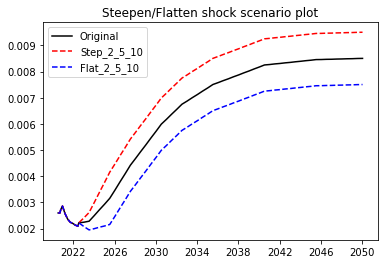

In [40]:
zeros_ori = dfs_2_zeros(L_dfs,Day_Count)
step_zeros = shock_cv_SF(zeros_ori,2,5,10,"S")
flat_zeros = shock_cv_SF(zeros_ori,2,5,10,"F")
plt.plot([ele[0] for ele in zeros_ori], [ele[1] for ele in zeros_ori],"k",label='Original')
plt.plot([ele[0] for ele in step_zeros], [ele[1] for ele in step_zeros],"r",linestyle='dashed',label='Step_2_5_10')
plt.plot([ele[0] for ele in flat_zeros], [ele[1] for ele in flat_zeros],"b",linestyle='dashed',label='Flat_2_5_10')
plt.legend()
plt.title("Steepen/Flatten shock scenario plot")
plt.show()

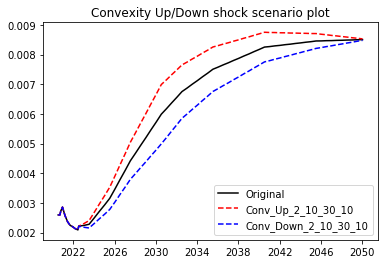

In [41]:
zeros_ori = dfs_2_zeros(L_dfs,Day_Count)
Up_zeros = shock_cv_CVX(zeros_ori,2,10,30,10,"UP")
Down_zeros = shock_cv_CVX(zeros_ori,2,10,30,10,"DOWN")
plt.plot([ele[0] for ele in zeros_ori], [ele[1] for ele in zeros_ori],"k",label='Original')
plt.plot([ele[0] for ele in Up_zeros], [ele[1] for ele in Up_zeros],"r",linestyle='dashed',label='Conv_Up_2_10_30_10')
plt.plot([ele[0] for ele in Down_zeros], [ele[1] for ele in Down_zeros],"b",linestyle='dashed',label='Conv_Down_2_10_30_10')
plt.legend()
plt.title("Convexity Up/Down shock scenario plot")
plt.show()

### Apply this method on top of a swap or a portfolio of swaps

In [42]:
# define the swap to run and fwd/discoutning curve
Day_Count = Day_Counter()
s_obj = swap_obj(swap_trade,Day_Count)
# USD Libor 6ML curve
L_dfs = L_BtS._get_dfs()
# USD OIS discounting curve
O_dfs = O_BtS._get_dfs()
NPV_cur = s_obj._cal_swap_NPV(L_dfs, O_dfs)

In [43]:
scenarios = [ "S_2_5_10","S_5_10_10","S_10_30_10",
              "F_2_5_10","F_5_10_10","F_10_30_10",
              "Up_2_10_30_10","Down_2_10_30_10",
             ]
answer = []
for ss in scenarios:
    zeros_i = dfs_2_zeros(L_dfs,Day_Count)
    ss_parse = ss.split("_")
    if ss_parse[0] in ("S","F"):
        new_zeros = shock_cv_SF(zeros_i,int(ss_parse[1]),int(ss_parse[2]),int(ss_parse[3]),ss_parse[0])
    else:
        # Convexity shock below:
        new_zeros = shock_cv_CVX(zeros_i,int(ss_parse[1]),int(ss_parse[2]),int(ss_parse[3]),int(ss_parse[4]),ss_parse[0])
    new_dfs = zeros_2_dfs(new_zeros,Day_Count)
    NPV_new = s_obj._cal_swap_NPV(new_dfs, O_dfs)
    answer.append({"Scenario":ss,"Impact":NPV_new-NPV_cur})
print(pd.DataFrame(answer))

          Scenario         Impact
0         S_2_5_10  507881.418421
1        S_5_10_10    1214.664894
2       S_10_30_10       0.000000
3         F_2_5_10 -507643.931809
4        F_5_10_10   -1215.318843
5       F_10_30_10       0.000000
6    Up_2_10_30_10  191230.316937
7  Down_2_10_30_10 -191197.094313


As we are currently simulating a swap stating year 0 and maturity in year 5, with 10 bps curve shock, we expect to see large changes when shock from year 2 to year 5 but no changes on shocks happends after year 5. Also if we shock the curve convexity up from year 2 to year 10 and then convexity down from year 10 to year 30, we expect to see the result should be less than half of the shocks from year 2 to year 5.